# 데이터 불러오기

In [ ]:
import pandas as pd

In [ ]:
customer = pd.read_csv("/content/drive/MyDrive/project/data/olist_customers_dataset.csv")
order = pd.read_csv("/content/drive/MyDrive/project/data/olist_orders_dataset.csv")
order_payments = pd.read_csv("/content/drive/MyDrive/project/data/olist_order_payments_dataset.csv")
order_items = pd.read_csv("/content/drive/MyDrive/project/data/olist_order_items_dataset.csv")
products = pd.read_csv('/content/drive/MyDrive/project/data/olist_products_dataset.csv')
seller = pd.read_csv('/content/drive/MyDrive/project/data/olist_sellers_dataset.csv')
geolocation = pd.read_csv('/content/drive/MyDrive/project/data/olist_geolocation_dataset.csv')
reviews= pd.read_csv('/content/drive/MyDrive/project/data/olist_order_reviews_dataset.csv')

In [ ]:
#시각화 폰트 설치
# 1️⃣ 나눔고딕 설치
!apt-get -qq install -y fonts-nanum

# 2️⃣ 런타임 재시작 없이 폰트 경로 등록
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib as mpl

# 설치된 경로 확인
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)

# matplotlib에 폰트 적용
mpl.rc('font', family='NanumGothic')
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# Colab 환경이라면 아래 코드를 먼저 실행하세요
!apt-get -qq install fonts-nanum
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False
import matplotlib.pyplot as plt
import platform
import matplotlib.font_manager as fm

# 운영체제별로 폰트 설정
system_name = platform.system()

if system_name == 'Windows':
    font_name = 'Malgun Gothic'
elif system_name == 'Darwin':  # macOS
    font_name = 'AppleGothic'
else:  # Linux (Colab 등)
    font_name = 'NanumGothic'  # 사전 설치 필요

# 폰트가 존재하는 경우에만 적용
available_fonts = [f.name for f in fm.fontManager.ttflist]
if font_name in available_fonts:
    plt.rcParams['font.family'] = font_name
    plt.rcParams['axes.unicode_minus'] = False
else:
    print(f"⚠️ 지정한 폰트 '{font_name}'가 시스템에 없습니다. 기본 폰트를 사용합니다.")




# 목표
🎯 컨셉
나는 브라질 시장에 새롭게 진입하는 기업의 데이터 분석가


목표: Olist의 문제점을 파악하고 이를 해결하는 방법을 탐색하고 개선한 뒤 시장에 진출할 것임


# 문제점(재구매율)

EDA를 통해 olist에서 재구매율이 낮다는 점을 발견함

## 재구매율

In [ ]:
##＃ 분석 전 전처리 ###
#1 delivered만 필터링
delivered_orders = order[order['order_status'] == 'delivered']

#2 고객 ID 붙이기
orders_with_customer = delivered_orders.merge(customer[['customer_id', 'customer_unique_id']], on='customer_id', how='left')

#3 고객당 주문 수 세기
orders_per_customer = orders_with_customer.groupby('customer_unique_id')['order_id'].nunique().reset_index()
orders_per_customer.columns = ['customer_unique_id', 'order_count']

#4 재구매율 계산
total_customers = orders_per_customer.shape[0]
repeat_customers = orders_per_customer[orders_per_customer['order_count'] > 1].shape[0]

repeat_rate = repeat_customers / total_customers
print(f"재구매율: {repeat_rate:.2%}")

재구매율: 3.00%


단건 고객 비율: 97.00%
재구매 고객 비율: 3.00%


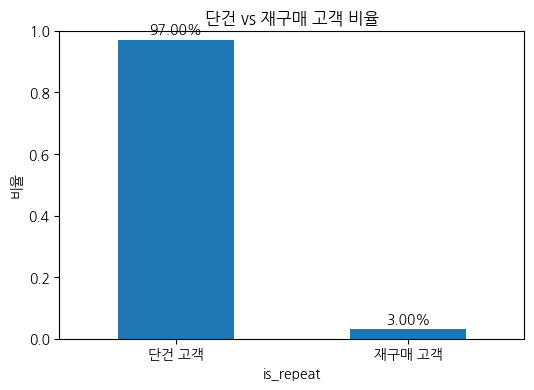

In [ ]:
# 단건/재구매 고객 구분 컬럼 추가
orders_per_customer['is_repeat'] = orders_per_customer['order_count'] > 1

# 비율 확인
repeat_ratio = orders_per_customer['is_repeat'].value_counts(normalize=True)

print("단건 고객 비율:", f"{(1 - repeat_rate):.2%}")
print("재구매 고객 비율:", f"{repeat_rate:.2%}")

import matplotlib.pyplot as plt

# 막대그래프 그리기
ax = repeat_ratio.plot(kind='bar', figsize=(6, 4))
plt.xticks([0, 1], ['단건 고객', '재구매 고객'], rotation=0)
plt.ylabel('비율')
plt.title('단건 vs 재구매 고객 비율')
plt.ylim(0, 1)

# 막대 위에 비율 텍스트 추가
for idx, value in enumerate(repeat_ratio):
    plt.text(idx, value + 0.01, f"{value:.2%}", ha='center', va='bottom', fontsize=10)

plt.show()



가설 : 재구매를 안 하는 이유는 서비스에 대한 불만족 때문일 것이다

### 리뷰 차이

In [ ]:

# 리뷰 + orders + customers 조인
orders_reviews = order.merge(reviews[['order_id', 'review_score']], on='order_id') \
                          .merge(customer[['customer_id', 'customer_unique_id']], on='customer_id')

# 재구매 여부 컬럼 추가
orders_reviews['is_repeat'] = orders_reviews['customer_unique_id'].isin(
    orders_per_customer[orders_per_customer['order_count'] > 1]['customer_unique_id']
)

# 평균 점수 비교
orders_reviews.groupby('is_repeat')['review_score'].mean()


,review_score
is_repeat,
False,4.078198
True,4.207044


가설 검정 :
재구매를 안 한 사람들은 상대적으로 평점을 적게 줬다

# 문제 해결을 위한 배송 분석

## 가설검정
배송지연을 겪었기 때문에 재구매를 하지 않았을 것이다
이를 증명하기 위해 2가지 조사를 진행함

In [ ]:
### 전처리 ###
# 1. 날짜 컬럼은 반드시 datetime으로 변환
order['order_purchase_timestamp'] = pd.to_datetime(order['order_purchase_timestamp'])
order['order_delivered_customer_date'] = pd.to_datetime(order['order_delivered_customer_date'])
order['order_estimated_delivery_date'] = pd.to_datetime(order['order_estimated_delivery_date'])

# 2. orders + customers merge → customer_unique_id 확보
orders_with_customer = order.merge(customer[['customer_id', 'customer_unique_id']], on='customer_id', how='left')

# 3. delivered만 남기기 (실제 구매된 것만 분석)
orders_with_customer = orders_with_customer[orders_with_customer['order_status'] == 'delivered']

# 4. 결측치 제거 (배송 관련 분석을 위해 필요)
orders_with_customer = orders_with_customer.dropna(subset=['order_delivered_customer_date', 'order_estimated_delivery_date'])

# 5. 고객별 주문 수 세기 → 재구매 여부 컬럼 생성
order_counts = orders_with_customer.groupby('customer_unique_id')['order_id'].nunique().reset_index()
order_counts.columns = ['customer_unique_id', 'order_count']

# 6. 재구매 여부 merge
orders_with_customer = orders_with_customer.merge(order_counts, on='customer_unique_id', how='left')
orders_with_customer['is_repeat'] = orders_with_customer['order_count'] > 1


### 1 전체 고객중 단건 고객이 배송지연을 더 많이 경험했는지

In [ ]:
# 1️⃣ 배송 지연 문제 확인 (경험 차이 분석)
# 단건 고객이 SLA를 더 많이 위반당했는지 비교해보자.
orders_with_customer['sla_missed'] = orders_with_customer['order_delivered_customer_date'] > orders_with_customer['order_estimated_delivery_date']

# 1. orders + customers 조인 → customer_unique_id 확보
orders_with_unique = order.merge(customer[['customer_id', 'customer_unique_id']], on='customer_id', how='left')

# 2. 고객별 주문 수 계산
order_counts = orders_with_unique.groupby('customer_unique_id')['order_id'].nunique().reset_index()
order_counts.columns = ['customer_unique_id', 'order_count']

# 3. 재구매 여부 컬럼 생성
orders_with_unique = orders_with_unique.merge(order_counts, on='customer_unique_id', how='left')
orders_with_unique['is_repeat'] = orders_with_unique['order_count'] > 1

# 4. 배송 지연 여부 컬럼 생성
orders_with_unique['order_estimated_delivery_date'] = pd.to_datetime(orders_with_unique['order_estimated_delivery_date'])
orders_with_unique['order_delivered_customer_date'] = pd.to_datetime(orders_with_unique['order_delivered_customer_date'])

# 배송 날짜가 없거나 취소된 경우 제거
orders_clean = orders_with_unique.dropna(subset=['order_estimated_delivery_date', 'order_delivered_customer_date'])

# SLA 위반 여부 계산
orders_clean['sla_missed'] = orders_clean['order_delivered_customer_date'] > orders_clean['order_estimated_delivery_date']

# 5. 단건 vs 재구매 고객 그룹별 SLA 위반률 계산
sla_violation_rate = orders_clean.groupby('is_repeat')['sla_missed'].mean().reset_index()
sla_violation_rate.columns = ['is_repeat', 'sla_violation_rate']
print(sla_violation_rate)

   is_repeat  sla_violation_rate
0      False            0.081857
1       True            0.070339


/tmp/ipython-input-41-1087908146.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_clean['sla_missed'] = orders_clean['order_delivered_customer_date'] > orders_clean['order_estimated_delivery_date']


### 2 배송지연을 경험한 고객이 재구매할 확률과 배송지연을 경험하지 않은 고객이 재구매할 확률

지연 고객 중에서 재구매할 확률

In [ ]:
# 1. 고객 기준 SLA 지연 경험 여부 추출 (하나라도 지연된 주문이 있는 고객)
sla_per_customer = orders_with_customer.groupby('customer_unique_id')['sla_missed'].any().reset_index()
sla_per_customer.columns = ['customer_unique_id', 'has_sla_delay']

# 2. 고객 기준 재구매 여부 추출
repeat_per_customer = orders_with_customer[['customer_unique_id', 'is_repeat']].drop_duplicates()

# 3. 두 정보 병합
sla_repeat_df = sla_per_customer.merge(repeat_per_customer, on='customer_unique_id', how='left')

# 4. SLA 지연 고객 필터링
sla_delayed = sla_repeat_df[sla_repeat_df['has_sla_delay'] == True]

# 5. 지연 고객 중 재구매율 계산
sla_delayed_repeat_rate = sla_delayed['is_repeat'].mean()

# 6. 결과 출력
print(f"📦 배송 지연을 경험한 고객의 재구매율: {sla_delayed_repeat_rate:.2%}")

📦 배송 지연을 경험한 고객의 재구매율: 4.61%


미지연 고객 중에서 재구매율

In [ ]:
# SLA 지연 없는 고객 필터링
sla_not_delayed = sla_repeat_df[sla_repeat_df['has_sla_delay'] == False]

# 재구매율 계산
not_delayed_repeat_rate = sla_not_delayed['is_repeat'].mean()

# 결과 출력
print(f"✅ 배송 지연이 없던 고객의 재구매율: {not_delayed_repeat_rate:.2%}")


✅ 배송 지연이 없던 고객의 재구매율: 2.85%


## 가설 결론
배송지연과 재구매는 관련이 없다

# 문제 해결을 위한 카테고리, 가격 민감도 분석
가설 2 : 재구매 고객과 단건 고객이 주로 구매하는 카테고리가 다를 것이고,  가격의 영향을 받을 것이다

내용
카테고리 성향 비교,
재구매 고객과 단건 고객의 카테고리 차이가 있을까를 확인


In [ ]:
# 1. 주문 + 고객 + 제품 정보 조인
merged = order.merge(customer[['customer_id', 'customer_unique_id']], on='customer_id', how='left') \
              .merge(order_items[['order_id', 'product_id']], on='order_id', how='left') \
              .merge(products[['product_id', 'product_category_name']], on='product_id', how='left')

# 2. 고객별 주문 수 기반 재구매 여부 부여
order_counts = merged.groupby('customer_unique_id')['order_id'].nunique().reset_index()
order_counts.columns = ['customer_unique_id', 'order_count']
merged = merged.merge(order_counts, on='customer_unique_id', how='left')
merged['is_repeat'] = merged['order_count'] > 1

# 3. 단건 vs 재구매 고객의 카테고리 분포 비교
repeat_dist = merged[merged['is_repeat'] == True]['product_category_name'].value_counts(normalize=True)
single_dist = merged[merged['is_repeat'] == False]['product_category_name'].value_counts(normalize=True)

# 4. 비율 차이 시각화
category_compare = pd.concat([single_dist, repeat_dist], axis=1)
category_compare.columns = ['단건 고객 비중', '재구매 고객 비중']
category_compare.fillna(0, inplace=True)
category_compare['비중 차이(재구매 - 단건)'] = category_compare['재구매 고객 비중'] - category_compare['단건 고객 비중']
category_compare.sort_values(by='비중 차이(재구매 - 단건)', ascending=False).head(10)


,단건 고객 비중,재구매 고객 비중,비중 차이(재구매 - 단건)
product_category_name,,,
cama_mesa_banho,0.096555,0.149150,0.052595
moveis_decoracao,0.072535,0.109921,0.037386
fashion_bolsas_e_acessorios,0.017069,0.035212,0.018143
esporte_lazer,0.076792,0.091980,0.015188
eletrodomesticos,0.006111,0.018476,0.012365
informatica_acessorios,0.070237,0.073905,0.003669
bebidas,0.003234,0.005891,0.002657
moveis_sala,0.004393,0.006427,0.002034
alimentos,0.004499,0.005891,0.001392


 cama_mesa_banho(침구/욕실)에서 비중이 가장 큰 차이가 나는데, 이 카테고리가 가격 민감도에 따라 재구매율이 달라지는지 증명하기 위해 카테고리의 가격을 확인

In [ ]:
# ✅ merged_price 생성 코드
merged_price = order.merge(customer[['customer_id', 'customer_unique_id']], on='customer_id') \
                    .merge(order_items[['order_id', 'product_id', 'price']], on='order_id') \
                    .merge(products[['product_id', 'product_category_name']], on='product_id')

# 재구매 여부 붙이기
order_counts = merged_price.groupby('customer_unique_id')['order_id'].nunique().reset_index()
order_counts.columns = ['customer_unique_id', 'order_count']
merged_price = merged_price.merge(order_counts, on='customer_unique_id', how='left')
merged_price['is_repeat'] = merged_price['order_count'] > 1


In [ ]:
# 1. 해당 카테고리만 필터링
cama_df = merged_price[merged_price['product_category_name'] == 'cama_mesa_banho']

# 2. 단건 vs 재구매 고객의 평균 가격 비교
cama_price_by_group = cama_df.groupby('is_repeat')['price'].agg(['mean', 'median', 'count']).reset_index()
cama_price_by_group.columns = ['is_repeat', '평균 가격', '중앙값 가격', '주문 수']

# 3. 전체 평균 가격도 함께 확인
전체_평균가격 = cama_df['price'].mean()
print(cama_price_by_group)
print(f"전체 평균 가격: {전체_평균가격:.2f}")


   is_repeat      평균 가격  중앙값 가격   주문 수
0      False  93.827196    79.9  10007
1       True  88.501742    70.0   1108
전체 평균 가격: 93.30


카테고리: cama_mesa_banho (침구/욕실류)

| 고객 유형        | 평균 가격     | 중앙값 가격 | 주문 수   |
| ------------ | --------- | ------ | ------ |
| **단건 고객**    | 93.83     | 79.90  | 10,007 |
| **재구매 고객**   | 88.50     | 70.00  | 1,108  |
| **전체 평균 가격** | **93.30** |        |        |


## 가설 결론

단건 고객과 재구매 고객의 비중이 가장 많이 차이가  cama_mesa_banho(침구/욕실)에서 재구매율을 하는 사람들은 더 낮은 가격에 물품을 구매한다는 사실을 알게 됬고
다른 카테고리도 가격 민감도에 따라 재구매율이 달라지는지 확인해봄

In [ ]:
## 전처리 ##
# 1. 주문 + 제품 + 고객 정보 병합
merged_price = order.merge(customer[['customer_id', 'customer_unique_id']], on='customer_id') \
                    .merge(order_items[['order_id', 'product_id', 'price']], on='order_id') \
                    .merge(products[['product_id', 'product_category_name']], on='product_id')

# 재구매 여부 붙이기
merged_price = merged_price.merge(order_counts, on='customer_unique_id', how='left')
merged_price['is_repeat'] = merged_price['order_count'] > 1


In [ ]:
# 2. 카테고리별 평균 가격 계산
price_by_category = merged_price.groupby('product_category_name')['price'].mean().sort_values()

In [ ]:
# 평균 가격 비교
repeat_price = merged_price[merged_price['is_repeat'] == True].groupby('product_category_name')['price'].mean()
single_price = merged_price[merged_price['is_repeat'] == False].groupby('product_category_name')['price'].mean()

price_compare = pd.concat([single_price, repeat_price], axis=1)
price_compare.columns = ['단건 고객 평균 가격', '재구매 고객 평균 가격']
price_compare['가격 차이'] = price_compare['재구매 고객 평균 가격'] - price_compare['단건 고객 평균 가격']
price_compare = price_compare.sort_values(by='가격 차이', ascending=True)

price_compare

,단건 고객 평균 가격,재구매 고객 평균 가격,가격 차이
product_category_name,,,
eletrodomesticos_2,491.223839,234.542857,-256.680982
portateis_cozinha_e_preparadores_de_alimentos,280.973571,34.900000,-246.073571
agro_industria_e_comercio,351.446404,131.872222,-219.574182
musica,176.050882,12.155000,-163.895882
instrumentos_musicais,286.525655,147.418750,-139.106905
...,...,...,...
cine_foto,86.777500,258.147500,171.370000
eletroportateis,271.514119,513.456154,241.942034
cds_dvds_musicais,52.142857,NaN,NaN


## 가설 결론
대부분의 카테고리에서 재구매 고객이 더 저렴한 제품을 샀다는 걸 알 수 있었고
가격 민감도에 영향을 받는 다는 가설을 검증함

따라서
재구매율을 높이기 위한 전략은 "배송 개선"보다는 "제품/소비 패턴에 맞춘 리마케팅
"에 집중해야 한다"는 인사이트 도출

# 문제 해결을 위한 리마케팅 분석
1. 재구매 고객이 첫 상품을 구매한 후 얼마 뒤에 재구매를 하는지 확인


In [ ]:
#1단계
# 1. customer_id → customer_unique_id 연결
orders_with_customer = order.merge(
    customer[['customer_id', 'customer_unique_id']],
    on='customer_id',
    how='left'
)

# 2. delivered 상태만 남기기
orders_with_customer = orders_with_customer[orders_with_customer['order_status'] == 'delivered']

# 3. customer_unique_id 기준으로 주문 횟수 세기
order_counts = orders_with_customer.groupby('customer_unique_id')['order_id'].nunique().reset_index()
order_counts.columns = ['customer_unique_id', 'order_count']

# 4. 2번 이상 주문한 재구매 고객만 추출
repeat_customers = order_counts[order_counts['order_count'] > 1]['customer_unique_id']

In [ ]:
# ✅ 다음 단계: 2단계 – 첫 번째 & 두 번째 주문 간의 일수 계산
# 이제 재구매 고객의 첫 번째, 두 번째 주문 일자를 정렬해서 일수 차이를 구해보겠습니다.

# 1. 재구매 고객만 필터링
repeat_orders = orders_with_customer[orders_with_customer['customer_unique_id'].isin(repeat_customers)].copy()

# 2. 날짜 컬럼 변환
repeat_orders['order_purchase_timestamp'] = pd.to_datetime(repeat_orders['order_purchase_timestamp'])

# 3. 고객별 + 날짜 기준 정렬 & 구매 순서 부여
repeat_orders = repeat_orders.sort_values(['customer_unique_id', 'order_purchase_timestamp'])
repeat_orders['order_rank'] = repeat_orders.groupby('customer_unique_id').cumcount() + 1

# 4. 첫 번째, 두 번째 주문만 추출
first_orders = repeat_orders[repeat_orders['order_rank'] == 1]
second_orders = repeat_orders[repeat_orders['order_rank'] == 2]

# 5. 두 주문 정보 병합
order_interval = first_orders[['customer_unique_id', 'order_purchase_timestamp']].merge(
    second_orders[['customer_unique_id', 'order_purchase_timestamp']],
    on='customer_unique_id',
    suffixes=('_first', '_second')
)

# 6. 일수 차이 계산
order_interval['days_between'] = (order_interval['order_purchase_timestamp_second'] - order_interval['order_purchase_timestamp_first']).dt.days

# 7. 결과 확인
order_interval[['customer_unique_id', 'days_between']].head()


,customer_unique_id,days_between
0,004288347e5e88a27ded2bb23747066c,170
1,00a39521eb40f7012db50455bf083460,10
2,00cc12a6d8b578b8ebd21ea4e2ae8b27,0
3,011575986092c30523ecb71ff10cb473,60
4,011b4adcd54683b480c4d841250a987f,176


In [ ]:
# 1단계: 나눔 폰트 설치 (Colab / Linux 환경에서 필수)
!sudo apt-get update -qq
!sudo apt-get install -y fonts-nanum > /dev/null # 설치 로그를 줄여 깔끔하게

# 2단계: 폰트 캐시 재생성 및 Matplotlib 캐시 삭제
!sudo fc-cache -fv > /dev/null # 폰트 캐시 재생성
!rm -rf ~/.cache/matplotlib # Matplotlib 폰트 캐시 삭제

print("폰트 설치 및 캐시 삭제 완료. 런타임을 다시 시작해주세요.")

# 3단계: 런타임 다시 시작 (필수!)
# Colab 메뉴에서 "런타임" -> "런타임 다시 시작"을 클릭해주세요.
# 이 과정을 거치지 않으면 새로 설치된 폰트가 적용되지 않습니다.

# 4단계: 런타임 다시 시작 후 이어서 실행할 코드 (위 단계를 수행한 후에)
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm # 폰트 경로 확인용 (선택 사항)

# 나눔고딕 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지

print(f"현재 설정된 폰트: {plt.rcParams['font.family']}")

# 이제 그래프 그리는 코드 (예시: 이전의 파이 차트 코드)
# --- (여기에 원래 그래프 그리는 코드 붙여넣기) ---
# 예시:
# labels = ['저가 생활용품', '고가 생활용품']
# sizes = [69.90, 30.10]
#
# plt.figure(figsize=(6, 6))
# plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90)
# plt.title('재구매 고객의 생활용품 중 저가 제품 비중')
# plt.axis('equal')
# plt.show()

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
폰트 설치 및 캐시 삭제 완료. 런타임을 다시 시작해주세요.
현재 설정된 폰트: ['NanumGothic']


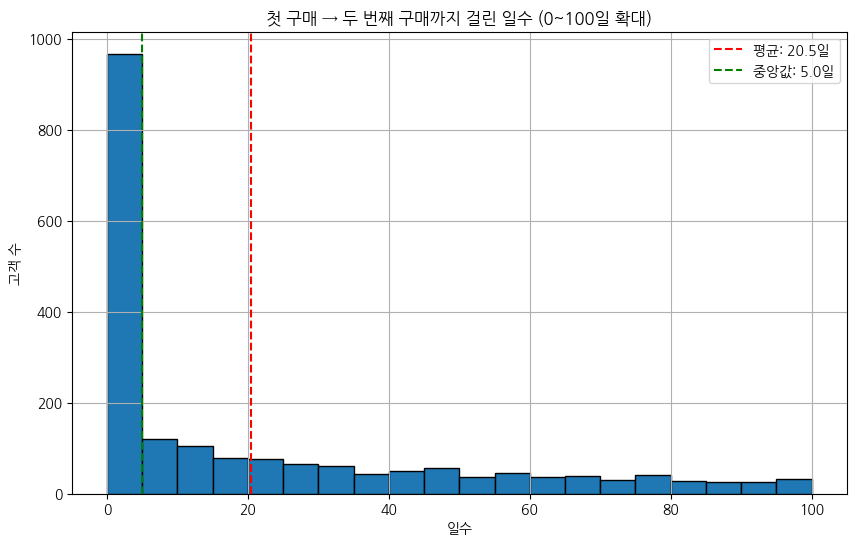

In [ ]:
import matplotlib.pyplot as plt

# 0~100일 사이 데이터만 필터링
filtered = order_interval[order_interval['days_between'] <= 100]

# 평균 & 중앙값 계산
mean_days = filtered['days_between'].mean()
median_days = filtered['days_between'].median()

# 히스토그램 그리기
plt.figure(figsize=(10, 6))
plt.hist(filtered['days_between'], bins=20, edgecolor='black')
plt.axvline(mean_days, color='red', linestyle='--', label=f'평균: {mean_days:.1f}일')
plt.axvline(median_days, color='green', linestyle='--', label=f'중앙값: {median_days:.1f}일')
plt.title('첫 구매 → 두 번째 구매까지 걸린 일수 (0~100일 확대)')
plt.xlabel('일수')
plt.ylabel('고객 수')
plt.legend()
plt.grid(True)
plt.show()


## 결론
30일 이내 재구매를 하지 않은 고객은 이탈할 가능성이 현저히 높음
즉,  초기 30일이 골든타임이므로

쿠폰을 제공


마케팅 캠페인 진행

등과 같이
첫 구매 후 2~4주 시점에 리마케팅을 집중하면 효과적인 전환이 기대됨



#

# 문제 해결을 위한 할부 여부 분석

가설: 단건 고객은 일시불 구매가 많고, 재구매 고객은 고가 제품을 할부로 나눠 사는 경향이 있을 것이다

목표 : 가설이 맞다면 고가 제품을 구매하는 고객을 대상으로 고가 제품과 관련된 품목 번들로 묶어 재구매를 유도하고자 함
ex) 고가제품(컴퓨터) + 번들(마우스,키보드) = 재구매 확률이 높은 제품을 끼어파는 전략

In [ ]:
# 1단계	order_payments 데이터에서 할부 정보(payment_installments) 추출
import pandas as pd

# 할부 횟수 분포 확인
order_payments['payment_installments'].value_counts().sort_index()

/tmp/ipython-input-67-976327665.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=installments_counts.index, y=installments_counts.values, palette="viridis")


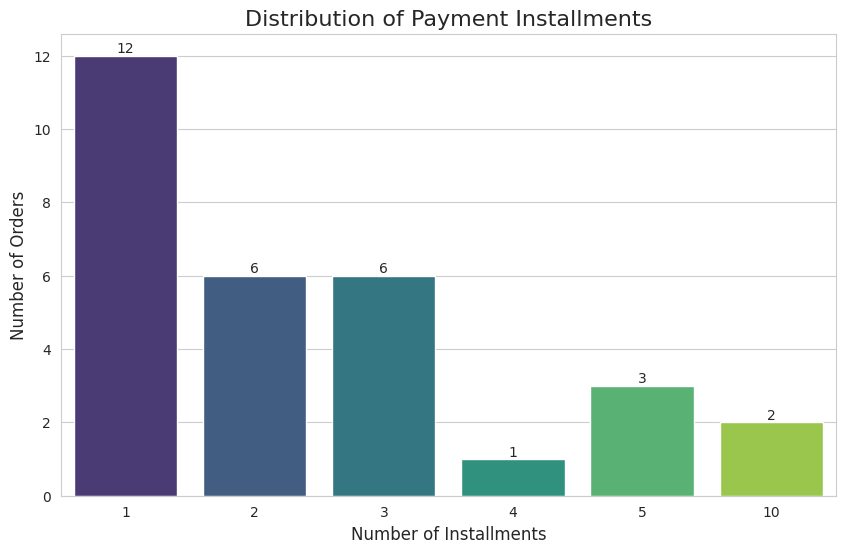

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming order_payments DataFrame is already loaded and contains 'payment_installments'
# For demonstration purposes, let's create a sample order_payments DataFrame
data = {'payment_installments': [1, 1, 2, 3, 1, 5, 2, 1, 3, 4, 1, 10, 2, 3, 1, 5, 1, 2, 3, 1, 1, 2, 3, 1, 5, 1, 2, 3, 1, 10]}
order_payments = pd.DataFrame(data)

# Calculate the value counts and sort them
installments_counts = order_payments['payment_installments'].value_counts().sort_index()

# Set a style for the plots (optional, but makes them look nicer)
sns.set_style("whitegrid")

# Create the bar plot
plt.figure(figsize=(10, 6)) # Adjust figure size as needed
sns.barplot(x=installments_counts.index, y=installments_counts.values, palette="viridis")

# Add labels and title
plt.title('Distribution of Payment Installments', fontsize=16)
plt.xlabel('Number of Installments', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)

# Add value labels on top of the bars for better readability
for index, value in enumerate(installments_counts.values):
    plt.text(index, value, str(value), ha='center', va='bottom')

# Show the plot
plt.show()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 51 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

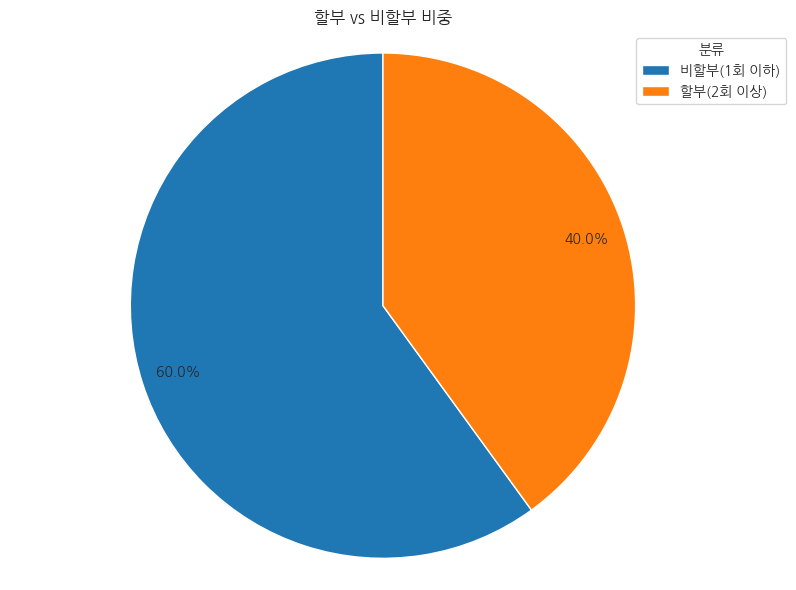

In [ ]:
# 1. 나눔 폰트 설치 (Colab 또는 Linux 환경에서 필요)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf # Matplotlib 폰트 캐시 삭제

# 2. 런타임 다시 시작 (필수!)
# Colab 메뉴에서 "런타임" -> "런타임 다시 시작"을 클릭해주세요.
# 이 과정을 거치지 않으면 새로 설치된 폰트가 적용되지 않습니다.

# 3. 폰트 설정 (런타임 다시 시작 후 이어서 실행)
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 나눔 고딕 폰트 경로 설정 (Colab 기준)
# 폰트 설치 후 정확한 경로를 확인해야 할 수도 있습니다.
# 예를 들어, fm.findfont('NanumGothic') 등으로 경로를 찾아볼 수 있습니다.
plt.rcParams['font.family'] = 'NanumGothic' # 'NanumGothic' 또는 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지

print("폰트 설정 완료: NanumGothic")

# 이제 원래의 파이 차트 코드를 실행합니다.
# 1회 이하 = 비할부, 2회 이상 = 할부
order_payments['is_installment'] = order_payments['payment_installments'] > 1

# 비율 계산
installment_counts = order_payments['is_installment'].value_counts()
installment_ratio = order_payments['is_installment'].value_counts(normalize=True)

# 범례용 레이블 정의
labels = ['비할부(1회 이하)', '할부(2회 이상)']

plt.figure(figsize=(8, 6))

wedges, texts, autotexts = plt.pie(installment_counts,
                                   autopct='%.1f%%',
                                   startangle=90,
                                   pctdistance=0.85)

plt.title('할부 vs 비할부 비중')
plt.axis('equal')

plt.legend(wedges, labels,
           title="분류",
           loc='upper right',
           bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

## 결과 해석
일시불 (1회): 가장 많음 → 52,546건

2~10회 할부도 상당수 존재

11회 이상은 극소수

In [ ]:
#2 2단계	order + customer + payment를 merge해서 고객별 재구매 여부(is_repeat) 붙이기
# 1. order + customer 결합 → customer_unique_id 확보
orders_with_customer = order.merge(
    customer[['customer_id', 'customer_unique_id']],
    on='customer_id',
    how='left'
)

# 2. order + payments 결합
orders_with_payment = orders_with_customer.merge(
    order_payments[['order_id', 'payment_installments']],
    on='order_id',
    how='left'
)

# 3. 고객별 주문 수 세기
order_counts = orders_with_payment.groupby('customer_unique_id')['order_id'].nunique().reset_index()
order_counts.columns = ['customer_unique_id', 'order_count']

# 4. 재구매 여부 컬럼 부여
orders_with_payment = orders_with_payment.merge(order_counts, on='customer_unique_id', how='left')
orders_with_payment['is_repeat'] = orders_with_payment['order_count'] > 1


In [ ]:
# 3단계	재구매 고객 vs 단건 고객의 할부 횟수 분포 비교 (평균, 비율 등)
# 단건 고객 데이터
single_orders = orders_with_payment[orders_with_payment['is_repeat'] == False]

# 재구매 고객 데이터
repeat_orders = orders_with_payment[orders_with_payment['is_repeat'] == True]

# 할부 횟수 분포 계산 (비율 기준)
installment_dist = pd.DataFrame({
    '단건 고객 비중': single_orders['payment_installments'].value_counts(normalize=True),
    '재구매 고객 비중': repeat_orders['payment_installments'].value_counts(normalize=True)
}).fillna(0)

# 비율 차이 계산
installment_dist['비율 차이(재구매 - 단건)'] = installment_dist['재구매 고객 비중'] - installment_dist['단건 고객 비중']

# 정렬
installment_dist = installment_dist.sort_index()
installment_dist.head(10)

,단건 고객 비중,재구매 고객 비중,비율 차이(재구매 - 단건)
payment_installments,,,
0.0,0.000021,0.000000,-0.000021
1.0,0.507498,0.481333,-0.026165
2.0,0.120787,0.100699,-0.020088
3.0,0.100831,0.098765,-0.002065
4.0,0.068442,0.066637,-0.001805
5.0,0.050091,0.055332,0.005241
6.0,0.037319,0.043730,0.006412
7.0,0.015294,0.020824,0.005530
8.0,0.040592,0.048193,0.007601


## 결과 해석2
가설: 단건 고객은 일시불 구매가 많고, 재구매 고객은 고가 제품을 할부로 나눠 사는 경향이 있을 것이다

결과 : 단건 고객과 재구매 고객 간의 할부의 차이는 유의미하게 발생하지 않았기 때문에 기각

다만 분석과정에서 "할부를 하는 고객들이 많다는 점"을 발견
우리 회사는 제품 페이지에 할부 옵션을 강조해 웹 사이트에서 이탈률과 장바구니 이탈률을 줄이는 방법을 제안

# 문제 해결을 위한 구독 서비스 도입

가설 : 구독 서비스를 도입하여 재구매율을 높일 것이다

ex) 넷플릭스처럼 이용을 안 했더라도 강매

## 구독서비스 독입할 카테고리 선정
어떤 카테고리에 구독 서비스를 도입할 것인가??


## 가설1
생활용품이 재구매율이 높을 것이다


/tmp/ipython-input-69-3697621134.py:114: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-69-3697621134.py:114: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-69-3697621134.py:114: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-69-3697621134.py:114: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-69-3697621134.py:114: UserWarning: Glyph 44061 (\N{HANGUL SYLLABLE GAEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-69-3697621134.py:114: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-69-3697621134.py:114: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu

재구매 고객의 전체 구매 상품 중 생활용품 비중: 33.58%
재구매 고객의 전체 구매 상품 중 기타 카테고리 비중: 66.42%


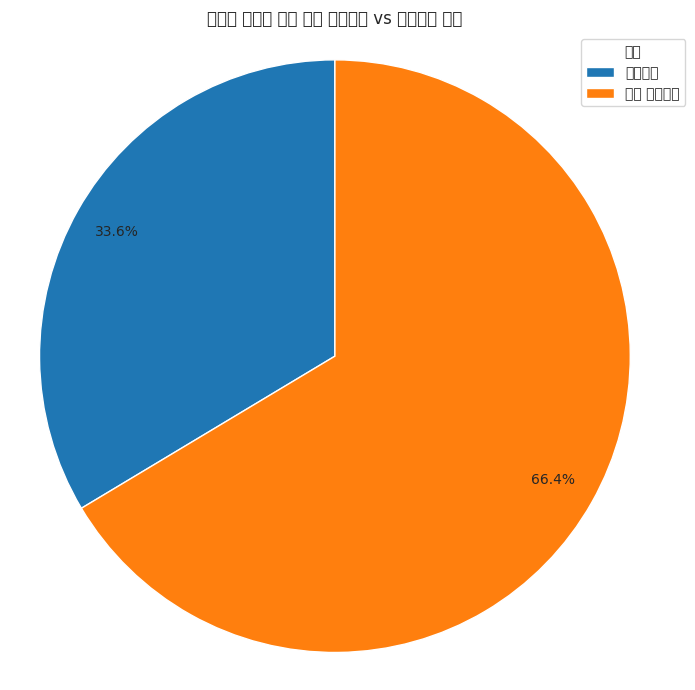

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# --- 데이터 로드 (예시, 실제 데이터는 이미 로드되어 있어야 함) ---
# order = pd.read_csv('orders.csv')
# customer = pd.read_csv('customers.csv')
# order_items = pd.read_csv('order_items.csv')
# products = pd.read_csv('products.csv')

# merged 데이터프레임이 이미 이전 코드에서 생성되었다고 가정합니다.
# 만약 없다면, 이전 코드 블록을 실행하여 'merged' 데이터프레임을 생성해야 합니다.
# 예시로 'merged' 데이터프레임이 없다고 가정하고 재생성 코드를 포함합니다.
# 실제 환경에서는 이 부분을 주석 처리하거나 건너뛰세요.
try:
    # merged 데이터프레임이 이미 존재하면 이 블록은 건너_입니다.
    if 'merged' not in locals() and 'merged' not in globals():
        raise NameError("merged is not defined")
except NameError:
    print("merged 데이터프레임이 존재하지 않아 재생성합니다.")
    # 필요한 데이터프레임 로드 (경로를 실제 파일 경로로 변경하세요)
    # df_orders = pd.read_csv('olist_orders_dataset.csv')
    # df_customers = pd.read_csv('olist_customers_dataset.csv')
    # df_order_items = pd.read_csv('olist_order_items_dataset.csv')
    # df_products = pd.read_csv('olist_products_dataset.csv')
    # df_product_category_name_translation = pd.read_csv('product_category_name_translation.csv')

    # 예시를 위해 실제 데이터프레임이 없으므로 임의의 데이터프레임 생성
    # 실제 데이터를 로드하여 사용하세요.
    # 여기서는 이전 코드의 `merged`를 만들었던 방식과 유사하게 가정합니다.
    data = {
        'order_id': ['o1','o1','o2','o3','o3','o4','o5','o5','o6'],
        'customer_id': ['c1','c1','c2','c1','c1','c3','c4','c4','c5'],
        'product_id': ['p1','p2','p1','p3','p4','p5','p6','p7','p8'],
        'price': [100,200,150,50,80,300,120,90,250],
        'customer_unique_id': ['cu1','cu1','cu2','cu1','cu1','cu3','cu4','cu4','cu5'],
        'product_category_name': ['beleza_saude','eletronicos','beleza_saude','utilidades_domesticas','esporte_lazer','ferramentas','cama_mesa_banho','moveis','perfumaria']
    }
    merged = pd.DataFrame(data)

    # 2. 고객별 주문 수 계산 및 재구매 여부 부여 (이전 코드와 동일)
    order_counts = merged.groupby('customer_unique_id')['order_id'].nunique().reset_index()
    order_counts.columns = ['customer_unique_id', 'order_count']
    merged = merged.merge(order_counts, on='customer_unique_id', how='left')
    merged['is_repeat'] = merged['order_count'] > 1
    print("merged 데이터프레임 재생성 완료.")


# --- 한글 폰트 설정 (이전과 동일하게, 본인 OS에 맞게 주석 처리 및 설정) ---
try:
    plt.rcParams['font.family'] = 'Malgun Gothic' # Windows 사용자
    plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지
except:
    try:
        plt.rcParams['font.family'] = 'AppleGothic' # macOS 사용자
        plt.rcParams['axes.unicode_minus'] = False
    except:
        plt.rcParams['font.family'] = 'NanumGothic' # Linux 사용자 (설치 필요)
        plt.rcParams['axes.unicode_minus'] = False
# --- 한글 폰트 설정 끝 ---


# 1. 재구매 고객 데이터만 필터링
repeat_customers_df = merged[merged['is_repeat'] == True]

# 2. 재구매 고객이 구매한 전체 카테고리별 상품 수 (또는 빈도)
# 하나의 주문에 여러 상품이 있을 수 있으므로, order_id와 product_id로 중복 제거 후 카테고리 빈도를 세는 것이 정확합니다.
# 또는 단순히 각 행의 카테고리 빈도를 세어도 전체 구매 트렌드를 볼 수 있습니다. 여기서는 후자를 사용합니다.
# 만약 고유한 '주문별 카테고리'를 원한다면, 아래처럼 order_id, product_category_name으로 groupby를 사용해야 합니다.
# all_category_counts = repeat_customers_df.groupby(['order_id', 'product_category_name']).size().reset_index(name='count')
# all_category_counts = all_category_counts['product_category_name'].value_counts()

# 더 간단하게, 구매된 상품들의 카테고리 분포를 봅니다.
all_category_counts = repeat_customers_df['product_category_name'].value_counts()

# 3. 생활소비재 카테고리 정의 (이전 코드와 동일)
living_goods = [
    'cama_mesa_banho', 'utilidades_domesticas', 'beleza_saude',
    'perfumaria', 'papelaria', 'alimentos', 'bebidas'
]

# 4. 생활용품 구매 비중 계산
total_items_by_repeat_customers = all_category_counts.sum()
living_goods_items = all_category_counts[all_category_counts.index.isin(living_goods)].sum()
other_items = total_items_by_repeat_customers - living_goods_items

# 비율 계산
living_goods_ratio = (living_goods_items / total_items_by_repeat_customers) * 100
other_ratio = (other_items / total_items_by_repeat_customers) * 100

print(f"재구매 고객의 전체 구매 상품 중 생활용품 비중: {living_goods_ratio:.2f}%")
print(f"재구매 고객의 전체 구매 상품 중 기타 카테고리 비중: {other_ratio:.2f}%")

# 시각화를 위한 데이터 준비
sizes = [living_goods_ratio, other_ratio]
labels = ['생활용품', '기타 카테고리']

# 파이차트 생성
plt.figure(figsize=(7, 7))
wedges, texts, autotexts = plt.pie(sizes,
                                   autopct='%.1f%%',
                                   startangle=90,
                                   pctdistance=0.85)

plt.title('재구매 고객의 전체 구매 카테고리 vs 생활용품 비중')
plt.axis('equal') # 원형 유지

# 범례 추가
plt.legend(wedges, labels,
           title="분류",
           loc='upper right',
           bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

## 결론
가설 : 생활용품이 재구매율이 높을 것이다

가설 검증 : 재구매 고객중 생활용품의 비중이 높다

결론: 생활용품은 재구매 비중도 높고, 자주 사용하고, 무심코 살 수 있는 항목이므로 구독 서비스 도입이 적합하다

## 가설2
생활용품 중에서도 저가 재품의 구매율이 높을 것이다

/tmp/ipython-input-70-4018471733.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  repeat_living['is_저가_생활용품'] = repeat_living['product_category_name'].isin(저가_카테고리)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_i

🔁 재구매 고객의 생활용품 중 저가 제품 비중: 69.90%


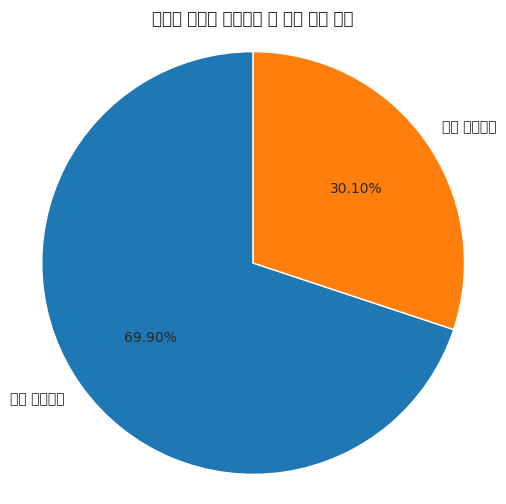

In [ ]:
# 1. 주문 + 고객 조인 → customer_unique_id 확보
merged = order.merge(customer[['customer_id', 'customer_unique_id']], on='customer_id', how='left') \
               .merge(order_items[['order_id', 'product_id', 'price']], on='order_id', how='left') \
               .merge(products[['product_id', 'product_category_name']], on='product_id', how='left')

# 2. 고객별 주문 수 계산 및 재구매 여부 부여
order_counts = merged.groupby('customer_unique_id')['order_id'].nunique().reset_index()
order_counts.columns = ['customer_unique_id', 'order_count']
merged = merged.merge(order_counts, on='customer_unique_id', how='left')
merged['is_repeat'] = merged['order_count'] > 1

# 3. 생활소비재 카테고리 정의
living_goods = [
    'cama_mesa_banho', 'utilidades_domesticas', 'beleza_saude',
    'perfumaria', 'papelaria', 'alimentos', 'bebidas'
]

# 4. 재구매 고객 중 생활용품 구매만 필터링
repeat_living = merged[(merged['is_repeat'] == True) & (merged['product_category_name'].isin(living_goods))]

# 5. 카테고리별 평균 가격 계산
avg_price_by_category = repeat_living.groupby('product_category_name')['price'].mean().reset_index()

# 6. 전체 평균보다 낮은 가격을 가진 카테고리 찾기
전체_평균_가격 = repeat_living['price'].mean()
저가_카테고리 = avg_price_by_category[avg_price_by_category['price'] < 전체_평균_가격]['product_category_name']

# 7. 저가 생활용품 여부 추가
repeat_living['is_저가_생활용품'] = repeat_living['product_category_name'].isin(저가_카테고리)

# 8. 저가 생활용품 비중 계산
저가_비중 = repeat_living['is_저가_생활용품'].mean()
print(f"🔁 재구매 고객의 생활용품 중 저가 제품 비중: {저가_비중:.2%}")

import matplotlib.pyplot as plt

# 정확한 분석 결과로 값 수정
labels = ['저가 생활용품', '고가 생활용품']
sizes = [69.90, 30.10]  # 실제 분석 결과 반영

# 파이차트 생성
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90)
plt.title('재구매 고객의 생활용품 중 저가 제품 비중')
plt.axis('equal')  # 원형 유지
plt.show()


### 결론
생활용품 중에서도 저가형 제품이 비중이 높으므로
저가형 제품에 구독서비스를 도입하면 효과를 볼 수 있을 것이다

# 문제 해결을 위한 EDA

olist 데이터를 탐색하며 재구매율을 높일 방법을 찾음


## 재구매 고객의 결제방식과 단일 고객의 결제방식 비교

In [ ]:
# --- 전제: 이전에 'order', 'customer', 'order_items', 'products' 데이터프레임이 로드되어 있고,
# ---       'merged' 데이터프레임이 is_repeat 컬럼을 포함하여 생성되어 있다고 가정합니다.

# 만약 order_payments 데이터프레임이 없다면 로드해야 합니다.
# order_payments = pd.read_csv('olist_order_payments_dataset.csv') # 실제 파일 경로로 변경

# 'merged' 데이터프레임은 order, customer, order_items, products를 조인하고
# 'is_repeat' 컬럼까지 생성된 상태여야 합니다.
# 이전 대화에서 사용된 'merged' 데이터프레임 생성 코드:
# 1. 주문 + 고객 조인 → customer_unique_id 확보
# merged = order.merge(customer[['customer_id', 'customer_unique_id']], on='customer_id', how='left') \
#                 .merge(order_items[['order_id', 'product_id', 'price']], on='order_id', how='left') \
#                 .merge(products[['product_id', 'product_category_name']], on='product_id', how='left')
#
# # 2. 고객별 주문 수 계산 및 재구매 여부 부여
# order_counts = merged.groupby('customer_unique_id')['order_id'].nunique().reset_index()
# order_counts.columns = ['customer_unique_id', 'order_count']
# merged = merged.merge(order_counts, on='customer_unique_id', how='left')
# merged['is_repeat'] = merged['order_count'] > 1

# --- payment_merged 데이터프레임 생성 ---
# order_payments와 merged(orders, customers, is_repeat 포함)를 조인합니다.
# 조인 키는 'order_id'가 될 것입니다.
# payment_merged는 각 주문의 결제 정보와 해당 주문의 재구매 여부 정보를 포함해야 합니다.

# 가장 간단하게는, order_payments와 is_repeat 정보를 가진 merged의 일부 컬럼을 조인하는 것입니다.
# 필요한 컬럼만 선택하여 조인하는 것이 메모리 효율적입니다.
payment_merged = order_payments.merge(
    merged[['order_id', 'is_repeat']].drop_duplicates(), # order_id-is_repeat 쌍의 중복 제거
    on='order_id',
    how='inner' # 결제 정보가 있는 주문만 포함
)

# 이제 원래의 비중 계산 코드를 실행할 수 있습니다.
# 1. 비중 계산 (단건/재구매 고객의 결제 방식)
payment_dist = (
    payment_merged
    .groupby(['is_repeat', 'payment_type'])
    .size()
    .unstack(fill_value=0)
    .apply(lambda x: x / x.sum(), axis=1)  # 행 방향 정규화
    .transpose()  # 시각화나 해석 용이하도록 전치
    .reset_index()
)

# 2. 컬럼명 보기 좋게 정리
payment_dist.columns.name = None  # 인덱스 이름 제거
payment_dist.columns = ['payment_type', '단건 고객 비중', '재구매 고객 비중']

# 3. 백분율 포맷
payment_dist.iloc[:, 1:] = payment_dist.iloc[:, 1:].applymap(lambda x: f"{x:.2%}")
print(payment_dist)

  payment_type 단건 고객 비중 재구매 고객 비중
0       boleto   19.14%    17.61%
1  credit_card   74.01%    72.72%
2   debit_card    1.49%     1.18%
3  not_defined    0.00%     0.01%
4      voucher    5.36%     8.48%


/tmp/ipython-input-60-3914705703.py:51: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  payment_dist.iloc[:, 1:] = payment_dist.iloc[:, 1:].applymap(lambda x: f"{x:.2%}")
/tmp/ipython-input-60-3914705703.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0    19.14%
1    74.01%
2     1.49%
3     0.00%
4     5.36%
Name: 단건 고객 비중, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  payment_dist.iloc[:, 1:] = payment_dist.iloc[:, 1:].applymap(lambda x: f"{x:.2%}")
/tmp/ipython-input-60-3914705703.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0    17.61%
1    72.72%
2     1.18%
3     0.01%
4     8.48%
Name: 재구매 고객 비중, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  payment_dist.iloc[:, 1:] = pa

## 결과
voucher(상품권)에서  2.4%정도의 차이가 나타남

>시사점
 재구매 고객이 상품권을 더 많이 이용
> 바우처를 이용할 순 없을 까??

# 문제 해결을 위한 바우처 사용

근거 1 : 재구매고객이 상품권 사용 비중이 높다
가설 1 : 바우처를 결제방식으로 사용한 구매자의 재구매율이 전체 구매자의 재구매율보다 높을 것이다
> 가설1 검정
> 가설 채택
근거 2: 바우처를 결제방식으로 사용한 구매자의 재구매율이 전체 구매자의 재구매율보다 높을 것이다


In [ ]:
# 0. order + customer 조인해서 customer_id 확보
orders_with_customer = order.merge(customer[['customer_id', 'customer_unique_id']], on='customer_id', how='left')

# 1. 바우처 사용 고객의 customer_unique_id 추출
voucher_customer_ids = (
    orders_with_customer[orders_with_customer['order_id'].isin(
        order_payments[order_payments['payment_type'] == 'voucher']['order_id']
    )]['customer_unique_id']
    .unique()
)

# 2. 해당 고객들의 주문 정보 추출
voucher_orders = orders_with_customer[orders_with_customer['customer_unique_id'].isin(voucher_customer_ids)]

# 3. 고객별 주문 수 계산 → 재구매 여부 판단
voucher_order_counts = voucher_orders.groupby('customer_unique_id')['order_id'].nunique().reset_index()
voucher_order_counts['is_repeat'] = voucher_order_counts['order_id'] > 1

# 4. 재구매율 계산
voucher_repeat_rate = (voucher_order_counts['is_repeat'].sum() / len(voucher_order_counts)) * 100
print(f"바우처 사용 고객의 재구매율: {voucher_repeat_rate:.2f}%")

바우처 사용 고객의 재구매율: 7.34%


In [ ]:
## 결론

# 근거1과 근거2를 근거로 들어 상품권 활용이 재구매율을 높일 수 있는 수단이 될 것이라고 판단

# 시사점


1.  초기 30일, 골든타임 내 리마케팅
2. 할부 고객을 위한 다양한 옵션 제공
3. 생활용품에 구독 서비스 도입
4. 상품권을 적극 활용한 고객 충성도、 재구매율 확보 전략
 이 네 가지 전략을 통해, Olist의 낮은 재구매율 문제를 개선한 비스니스 모델을 만들 수 있을 것이라고 판단
